<a href="https://colab.research.google.com/github/davidislip/SVM-and-MVO/blob/main/Joint_Optimization_3_Factor_OOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integration of SVM and MVO 
The idea is to integrate support vector machines and mean variance optimization 

$$
\begin{align} 
\min_{x, z, w, b} \quad & x^{\intercal}\Sigma x + \frac{1}{2}||{w}||^2 &\\ 
\textrm{s.t.} \quad & \mu^\intercal x  \geq \bar{R} \\
\quad & z_i \leq M x_i &\forall i = 1,2,...,N  \\
\quad & x_i \leq z_i \quad &\forall i = 1,2,...,N \\
              \quad & y_i^{\intercal} w + b \leq M z_i - \epsilon \quad & \forall i = 1,2,...,N \\
              \quad & -M(1-z_i) + \epsilon \leq  y_i^{\intercal} w + b \quad &\forall i = 1,2,...,N \\
              \quad & x \in \mathcal{C} \quad z \in \{0,1\}^N & \\
\end{align} 
$$

This notebook focuses on the out of sample evaluation of the proposed methodlogy

In [56]:
!sudo python -m pip install gurobipy==9.1.2
import gurobipy as gp
from gurobipy import GRB
from google.colab import drive 
drive.mount('/content/gdrive')
from math import sqrt
import sys
pth = 'gdrive/My Drive/Colab Notebooks/'
sys.path.append(pth + 'SVM MVO/PYFILES/')
from packages import *
import random
%matplotlib inline

## Import Forecasts
forecasts = pd.read_pickle(pth +'SVM MVO/DATA/Forecasts.pkl')
## Import Returns
rets = pd.read_pickle(pth + 'SVM MVO/DATA/RETS.pkl')
## Import feature vectors
wrds_svm = pd.read_pickle(pth + 'SVM MVO/DATA/WRDS_ASOF.pkl')
## Import Monthly Prices
prices = pd.read_pickle(pth + 'SVM MVO/DATA/PRICES.pkl')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [57]:
e = gp.Env(empty=True)
#e.setParam('OutputFlag', 0)
gurobi_licence = pd.read_csv(pth +'SVM MVO/DATA/gurobi.csv')
e.setParam('WLSACCESSID', gurobi_licence.WLSACCESSID[0])
e.setParam('LICENSEID', gurobi_licence.LICENSEID[0])
e.setParam('WLSSECRET', gurobi_licence.WLSSECRET[0])
e.start()

Changed value of parameter WLSACCESSID
Changed value of parameter LICENSEID
Changed value of parameter WLSSECRET
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Using license file /usr/local/lib/python3.7/dist-packages/gurobipy/.libs/gurobi.lic
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID


<gurobipy.Env, No parameter changes>

In [58]:
mth = rets.index[0]
mth

Timestamp('2000-07-01 00:00:00')

In [224]:
#convenient function
sign = lambda a: int((a>0)) - int((a<0))

#preprocessing 
cov_, mean_ = forecasts[mth]
N = len(mean_)
cov = cov_[:N,:N]
mean = mean_[:N,:]
tics = list(rets.columns[:N])
print("valid tickers:", tics)

#get the wharton research data for the valid tickers for the month
wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(mth, level="MonthStart")

#restrict the wharton research data to the columns of interest
Y = wrds_tics.loc[:,"ROC1":"Vol"] # Y matrix in formulation as per the paper
Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0)) #scale the features 
cols = ['GRW1', 'LEV1', 'Momentum'] #Use Growth, Leverage and Momentum as factors
                                    #for the SVM
Y_ = Y_[cols]

ret_constr = -1
soft_margin = 2000

valid tickers: ['AAPL', 'ABC', 'ABMD', 'ABT', 'ADBE', 'ADI', 'ADM', 'ADP', 'ADSK', 'AEE', 'AEP', 'AES', 'AJG', 'AKAM', 'ALB', 'ALK', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMT', 'AMZN', 'ANSS', 'AON', 'AOS', 'APA', 'APD', 'APH', 'ATO', 'AVY', 'AZO', 'BA', 'BAX', 'BBY', 'BDX', 'BKNG', 'BLL', 'BMY', 'BSX', 'BWA', 'CAG', 'CAH', 'CAT', 'CCI', 'CCL', 'CDNS', 'CERN', 'CHD', 'CHRW', 'CI', 'CL', 'CLX', 'CMCSA', 'CMI', 'CMS', 'CNP', 'COO', 'COP', 'COST', 'CPB', 'CPRT', 'CSCO', 'CSX', 'CTAS', 'CTSH', 'CTXS', 'CVS', 'CVX', 'D', 'DD', 'DGX', 'DHR', 'DIS', 'DISH', 'DLTR', 'DOV', 'DRI', 'DTE', 'DUK', 'DVA', 'DVN', 'DXC', 'EA', 'EBAY', 'ECL', 'ED', 'EFX', 'EIX', 'EL', 'EMN', 'EMR', 'EOG', 'ES', 'ETN', 'ETR', 'EVRG', 'EXC', 'EXPD', 'F', 'FAST', 'FCX', 'FDX', 'FE', 'FFIV', 'FISV', 'FLS', 'FMC', 'GD', 'GIS', 'GLW', 'GPC', 'GPS', 'GWW', 'HAL', 'HAS', 'HD', 'HES', 'HFC', 'HOG', 'HOLX', 'HON', 'HP', 'HPQ', 'HRB', 'HRL', 'HSIC', 'HSY', 'HUM', 'IBM', 'IDXX', 'IEX', 'IFF', 'INCY', 'INTC', 'INTU', 'IP', 'IPG', 'IRM', 

In [159]:
print(wrds_svm.columns[(wrds_svm == np.inf).any(axis = 0).values])

Index([], dtype='object')


In [226]:
import time
def cb(model, where):
    if where == GRB.Callback.MIPNODE:
        # Get model objective
        obj = model.cbGet(GRB.Callback.MIPNODE_OBJBST)

        # Has objective changed?
        if abs(obj - model._cur_obj) > 1e-8:
            # If so, update incumbent and time
            model._cur_obj = obj
            model._time = time.time()

    # Terminate if objective has not improved in 120s
    if time.time() - model._time > 60:
        model.terminate()


class SVMMVO:

  bigM = 100
  epsilon = 0.01
  def __init__(self, tics, mean_ret, cov, ret_constr, soft_margin, exogenous, \
               svm_choice = (False, False), print_var_frntr = False):
    self.tics = tics #list of tickers
    self.mean_ret = mean_ret
    self.cov = cov
    self.ret_constr = ret_constr

    self.soft_margin = soft_margin #hyper parameter
    self.exogenous = exogenous # matrix of features for the tickers
    self.svm_constr, self.slacks = svm_choice #Model configuration
    N, m = self.exogenous.shape

    self.model = gp.Model(env = e)
    self.x = self.model.addMVar(N)
    self.w = self.model.addMVar(m)
    self.b = self.model.addMVar(1)
    self.z = self.model.addMVar(N, vtype=GRB.BINARY)
    self.xi = self.model.addMVar(N, lb = np.zeros(N))
    self.print_var_frntr = print_var_frntr
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    self.model.update()

    self.abs = self.model.addMVar(N)

  @property
  def portfolio_risk(self):
    return self.x @ self.cov @ self.x

  @property
  def port_exptd_ret(self):
    return self.mean_ret[:,0] @ self.x
  @property
  def soft_penalty(self):
    N, m = self.exogenous.shape
    return (self.soft_margin/N)*self.xi.sum()
    
                      
  @property
  def describe(self):
    if self.svm_constr:
      if self.slacks:
        desc = "SVM MVO with Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_Slck_ret"+str(self.ret_constr)
      else:
        desc = "SVM MVO with no Slacks with return = "+str(self.ret_constr)
        shrt = "SVMMVO_ret"+str(self.ret_constr)
    else:
      desc = "Traditional MVO with return = "+str(self.ret_constr)
      shrt = "MVO_ret"+str(self.ret_constr)
    return (desc, shrt)
  
  def print_var_info(self, names = {}):
    #dictionary of variables and thier names
    for key in names.keys():
      print(key, names[key])
    print("x", self.x.X)
    print("w", self.w.X)
    print("z", self.z.X)
    print("xi", self.xi.X)
    print("")

  def setModel(self):
    #remove constraints
    self.model.remove(self.model.getConstrs())
    #parameter definitions
    N, m = self.exogenous.shape
    bigM = SVMMVO.bigM
    epsilon = SVMMVO.epsilon
    #objective function components
    svm_margin = (1/2)*(self.w @ self.w)
    soft_penalty = (self.soft_margin/N)*self.xi.sum()
    
    self.model.remove(self.ret_target)
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    
    self.model.update()
    self.model.addConstr(self.x.sum() == 1, 'budget')

    if not self.svm_constr and self.slacks:
      #if we do not want to use svm then dont use svm with slack
      print("Cannot SVM with slack without SVM ... self.slacks set to False")
      self.slacks = svm_constr

    if self.svm_constr:
      self.model.addConstr(self.x <= self.z, "z force x" )  #if x is close to zero then z must be zero 
      self.model.addConstr(self.z <= 100*bigM*self.x, "z force x" )  # if z is zero then x must be zero 
      self.model.addConstr(self.b <= 0.5*epsilon, "b" ) # if z is zero then x must be zero 
      self.model.addConstr(self.b >= -0.5*epsilon, "b" ) # if z is zero then x must be zero 
 
      if self.slacks: #SVM MVO with slack variables
        self.model.setObjective(self.portfolio_risk + svm_margin + self.soft_penalty, GRB.MINIMIZE) 
        #adding the SVM type constraints
        for i in range(N):
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= (-1)*epsilon + self.xi[i] + (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + epsilon - self.xi[i] <= y_i @ self.w + self.b , "svm2" )

      else: #SVM MVO without slack variables - may not be feasible
        self.model.remove([self.xi])
        self.model.setObjective(self.portfolio_risk + svm_margin, GRB.MINIMIZE) 
        #adding the SVM type constraints
        for i in range(N): 
          y_i = self.exogenous.iloc[i].values
          self.model.addConstr(self.w @ y_i + self.b <= (-1)*epsilon +  (bigM)*self.z[i], "svm1" ) 
          self.model.addConstr(-1*  (bigM) *(1 - self.z[i])  + epsilon <= y_i @ self.w + self.b  , "svm2" )

    else:#not svm mvo
      self.model.setObjective(self.portfolio_risk, GRB.MINIMIZE)
      self.model.remove([self.w, self.b, self.z, self.xi])

  def optimize(self,callback = None):

    if callback not in [None]:
      self.model._cur_obj = float('inf')
      self.model._time = time.time()
      self.model.optimize(callback = callback)
    else:
      self.model.optimize()
    self.model.write('portfolio_selection_optimization.lp')

  def evaluate(self, realized_ret):

    ret = np.dot(self.x.X, realized_ret)
    return ret #use this to calculate out of sample rets and var

  def get_estimates(self):

    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    return [vol_metric, expt_ret_metric] #use this for efficient frontiers

  def get_results(self, export_dir = '', fig_size = ()):

    lng, shrt = self.describe
    vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
    expt_ret_metric = self.port_exptd_ret.getValue()[0]
    results = pd.DataFrame(data=np.append(self.x.X, [vol_metric, expt_ret_metric]),
    index= list(self.tics) + ['Volatility', 'Expected Return'], columns=[lng])

    if (export_dir != ''):
      results.to_csv(export_dir+'results.csv')

    if fig_size != () and type(fig_size) in [list, tuple]:
      results[:-2].plot.bar(figsize = fig_size)

    return  results.transpose()

  def get_frontier(self, export_dir = '', fig_size = (10,8)):

    N, m = self.exogenous.shape
    F = 25
    mean_ret = self.mean_ret[:,0]
    #F is the number of portfolios to use for frontier
    frontier = np.empty((2,F))
    #ws will contain the w's and b values for each portfolio 
    ws = np.empty((F, m+1))
    #xis will contain the w's and b values for each portfolio 
    xis = np.empty((F, N))
    #targets for returns
    ret_targ = np.linspace(mean_ret.min(), mean_ret.max(), F)

    expt_ret_metric = self.port_exptd_ret.getValue()[0]

    self.model.remove(self.ret_target)
    self.model.update()

    self.ret_target = self.model.addConstr(self.port_exptd_ret == expt_ret_metric, 'target ==')
    self.model.update()

    for i in range(F):
      self.ret_target[0].rhs = ret_targ[i]
      self.model.optimize()

      if  self.model.status == 4:
        break

      vol_metric = np.sqrt(self.portfolio_risk.getValue())[0]
      frontier[:,i] = np.array([vol_metric,ret_targ[i]])

      if self.svm_constr and self.slacks:
        ws[i,:] = np.concatenate([self.w.x, self.b.x])
        xis[i,:] = self.xi.x
        if self.print_var_frntr:
          self.print_var_info({"return": ret_targ[i]})

    if  self.model.status == 4:
      print("Resolving Model to initial state (return target) then exiting")
      self.model.remove(self.ret_target)
      self.model.update()
      self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
      self.model.optimize()
      return (None, None, None)

    #restore model to original state
    self.model.remove(self.ret_target)
    self.model.update()
    self.ret_target = self.model.addConstr(self.port_exptd_ret >= self.ret_constr, 'target')
    self.model.optimize()

    fig, ax = plt.subplots(figsize=fig_size)
    # Plot efficient frontier
    ax.plot(frontier[0], frontier[1], '-*', label='Efficient Frontier', color='DarkGreen')

    # Format and display the final plot
    ax.axis([frontier[0].min()*0.7, frontier[0].max()*1.3, mean_ret.min()*1.2, mean_ret.max()*1.2])
    ax.set_xlabel('Volatility (standard deviation)')
    ax.set_ylabel('Expected Return')
    # ax.legend()
    ax.grid()
    plt.show()
    if (export_dir != ''):
      plt.savefig(export_dir+"EfficientFrontier.png")
    return (frontier, ws, xis)

  def define_turnover(self, x0, Prices, Limit, cost):
    for v, absv, curr in zip(self.x.tolist(), self.abs.tolist(), x0.tolist()):
      self.model.addConstr(absv >= v - curr)
      self.model.addConstr(absv >= curr - v)
    q = cost*1/np.maximum(1, Prices)
    self.model.addConstr(self.abs @ q <= Limit)

### Simple Min Variance Portfolio 

In [227]:
MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_,\
             svm_choice = (False, False), print_var_frntr= False) #define an instance of the class
MVO.setModel() #set up the model
MVO.optimize() #find optimal solution

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 2 rows, 572 columns and 572 nonzeros
Model fingerprint: 0xdc0310da
Model has 41041 quadratic objective terms
Coefficient statistics:
  Matrix range     [2e-04, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 6e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 0 rows and 286 columns
Presolve time: 0.04s
Presolved: 2 rows, 286 columns, 572 nonzeros
Presolved model has 41041 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 285
 AA' NZ     : 4.104e+04
 Factor NZ  : 4.133e+04 (roughly 1 MByte of memory)
 Factor Ops : 7.921e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Du

### Mean Variance and SVM Joint Formulation

In [228]:
SVM_MVO = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, \
                 svm_choice = (True, False), print_var_frntr = False )
SVM_MVO.setModel()
SVM_MVO.optimize(callback = cb)

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 1148 rows, 862 columns and 4578 nonzeros
Model fingerprint: 0x44fcc6fa
Model has 41044 quadratic objective terms
Variable types: 576 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+02]
Presolve removed 171 rows and 358 columns
Presolve time: 0.07s
Presolved: 977 rows, 504 columns, 3714 nonzeros
Presolved model has 36588 quadratic objective terms
Variable types: 274 continuous, 230 integer (230 binary)

Root relaxation: objective 2.042613e-03, 610 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Dept

### Mean Variance and SVM Joint Formulation with Slacks

In [229]:
#SVM with slack 
SVM_MVO_Slck = SVMMVO(tics, mean, cov, ret_constr, soft_margin, Y_, \
                      svm_choice = (True, True), print_var_frntr = True )
SVM_MVO_Slck.setModel()
SVM_MVO_Slck.optimize()

Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Optimize a model with 1148 rows, 1148 columns and 5150 nonzeros
Model fingerprint: 0xb9d135a3
Model has 41044 quadratic objective terms
Variable types: 862 continuous, 286 integer (286 binary)
Coefficient statistics:
  Matrix range     [2e-04, 1e+04]
  Objective range  [7e+00, 7e+00]
  QObjective range [6e-07, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-03, 1e+02]
Found heuristic solution: objective 4.000000e+12
Presolve removed 3 rows and 286 columns
Presolve time: 0.03s
Presolved: 1145 rows, 862 columns, 4822 nonzeros
Presolved model has 41044 quadratic objective terms
Variable types: 576 continuous, 286 integer (286 binary)

Root relaxation: objective 1.386821e-03, 597 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective

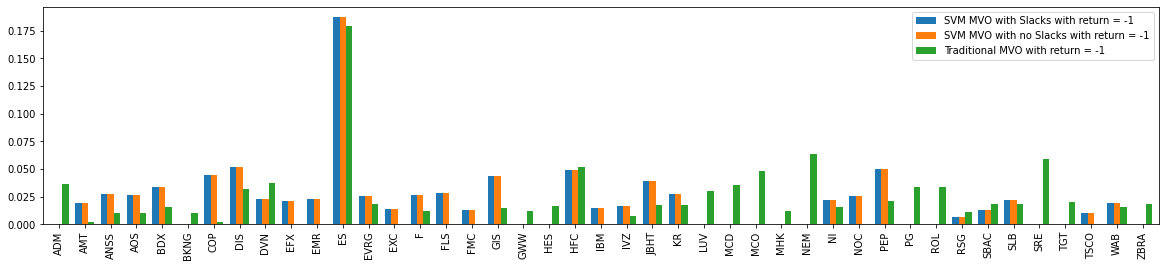

In [230]:
#portfolio comparison
out = pd.concat([SVM_MVO_Slck.get_results(), SVM_MVO.get_results(), MVO.get_results()], axis = 0)
out[out.columns[(out > 0.01).any(axis = 0)]].transpose()[:-2].plot.bar(figsize = (20,4), width = 0.75);

In [251]:
return_premium = 0.1 #similiar to Costa and Kwon 
#Limit = 0.75/6 #1/6 because Costa and Kwon use 1 for 6 month period. 
T = len(rets.index)

def evaluate_model(rets, forecasts, wrds_svm, return_premium, model_instance, T, N, cols, Limit):
  lr = 0.1 #learning rate for the SVM support vector
  weights = np.zeros([T,N])
  oot_returns = np.zeros(T)
  market = np.zeros(T)
  M = len(cols)
  wis = np.zeros([T,M])

  i = 0 #index for dates
  w_mabs = 0 #initialize
  soln_mods = {}
  for prd in rets.index.to_list()[:T]:
    ret_ = rets.loc[prd][:N]
    cov_, mean_ = forecasts[prd]
    cov = cov_[:N,:N]
    mean = mean_[:N,:]
    tics = list(rets.columns[:N])
    return_premium_temp = return_premium 
    #get the wharton research data for the valid tickers for the month
    wrds_tics = wrds_svm[wrds_svm.index.get_level_values('tic').isin(tics)].xs(prd, level="MonthStart")
    #restrict the wharton research data to the columns of interest
    wrds_tics['Momentum'] = mean 
    Y = wrds_tics.loc[:,cols] # Y matrix in formulation 
    Y_ =  (Y - Y.mean(axis=0))/(Y.std(axis=0))
    ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium)
    model_instance.tics = tics
    model_instance.ret_constr = ret_constr
    model_instance.mean_ret = mean
    model_instance.cov = cov
    model_instance.exogenous = Y_
    if i > 0: #not the first trade gets a constraint on turnover
      x_prev = model_instance.x.X

    if model_instance.svm_constr:
      w_mabs = (i/(i+1))*w_mabs + (1/(i+1))*np.abs(model_instance.w.x).mean()
      w_prev = model_instance.w.x

    model_instance.setModel()

    if i > 0: #not the first trade gets a constraint on turnover
      model_instance.define_turnover(x_prev, np.ones_like(x_prev), Limit, 1)

    if model_instance.svm_constr:
      u = model_instance.model.addMVar(M, lb = np.zeros(M), ub = np.ones(M))
      wcon1 = model_instance.model.addConstr(model_instance.w <= w_prev + lr*w_mabs*u + model_instance.epsilon, 'iter constraint 1')
      wcon2 = model_instance.model.addConstr(model_instance.w >= w_prev - lr*w_mabs*u - model_instance.epsilon, 'iter constraint 2')

    model_instance.model.Params.LogToConsole = 0
    
    model_instance.optimize(callback = cb)
    k = 1
    while model_instance.model.status == 4:
      #if the model is infeasible the decrease the return constraint
      #we do not have enough turnover the modify the portfolio to achive the 
      #return target... not a great place to be
      return_premium_temp = return_premium - 0.05*k
      ret_constr = mean.mean()*(1 + sign(mean.mean())*return_premium_temp)
      model_instance.ret_constr = ret_constr
      model_instance.ret_target[0].rhs = ret_constr
      model_instance.optimize(callback = cb)
      k = k+1
      #relax the return target bc the turnover constraint isnt allowing it to solve
    oot_returns[i] = model_instance.evaluate(ret_)
    market[i] = ret_.mean()
    weights[i, :] = model_instance.x.x
    if model_instance.model.IsMIP:
      soln_mods[prd] = [model_instance.model.MIPGap, return_premium_temp]
    else:
      soln_mods[prd] = return_premium_temp
    if model_instance.svm_constr:
      wis[i,:] = model_instance.w.x
      # if model_instance.w.x >= w_prev + lr*w_mabs  and wcon2.Pi < 10**(-7):
      #   lr = lr/2
    if i + 1 >= T:
      break
    if i%12 == 0:
      print("_"*25)
      print("Iteration ", i)
      print("Percent Complete ", i/T)
    i = i+1
  
  weights = pd.DataFrame(weights, index = rets.index[:T], columns = model_instance.tics)
  oot_returns = pd.Series(oot_returns, index = rets.index[:T])
  market = pd.Series(market, index = rets.index[:T])
  return (weights, oot_returns, market, wis, soln_mods)

def max_dd(returns):
    """Assumes returns is a pandas Series"""
    r = returns.add(1).cumprod()
    dd = r.div(r.cummax()).sub(1)
    mdd = dd.min()
    end = dd.argmin()
    start = r.iloc[:end].argmax()
    return mdd, start, end

def RetStats(returns):
    """Assumes returns is a pandas Series"""
    P = 12
    P05 = P**0.5
    return P*returns.mean(), P05*returns.std(), P*returns.mean()/(P05*returns.std())

def wealth(returns):
  """Assumes returns is a pandas Series"""
  return (1 + returns).cumprod()


In [252]:
mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO, T, N, cols, 1/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/mvo__oot_results__turnover1by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);
svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 1/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_oot_results_turnover1by6.pkl", 'wb') as fp:
  pkl.dump(svm_results, fp);

mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO, T, N, cols, 0.75/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/mvo__oot_results__turnover0_75by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);
svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 0.75/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_oot_results_turnover0_75by6.pkl", 'wb') as fp:
  pkl.dump(svm_results, fp);

mvo_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, MVO, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/mvo__oot_results__turnover1_25by6.pkl", 'wb') as fp:
  pkl.dump(mvo_results, fp);
svm_results = evaluate_model(rets, forecasts, wrds_svm, return_premium, SVM_MVO_Slck, T, N, cols, 1.25/6)
with open("gdrive/My Drive/Colab Notebooks/SVM MVO/DATA/svm_oot_results_turnover1_25by6.pkl", 'wb') as fp:
  pkl.dump(svm_results, fp);

weights_mvo, oot_returns_mvo, market_mvo, wis_mvo, soln_mods_mvo = mvo_results
weights_svm, oot_returns_svm, market_svm, wis_svm, soln_mods_svm = svm_results

Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
_________________________
Iteration  0
Percent Complete  0.0
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-commercial use only - registered to ryan.islip@mail.utoronto.ca
Academic license - for non-co

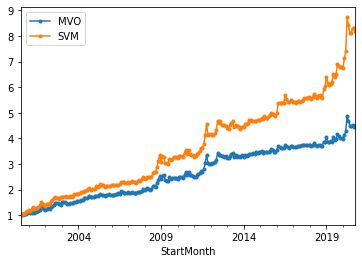

In [253]:
(wealth(oot_returns_mvo)/wealth(market_svm)).plot(label = 'MVO', marker = '.');
(wealth(oot_returns_svm)/wealth(market_svm)).plot(label = 'SVM', marker = '.');
#wealth(market_svm).plot(label = 'Equal Weight');
#wealth(rets.iloc[:,:N].max(axis=1)).plot(label = 'Max Possible');
plt.legend();

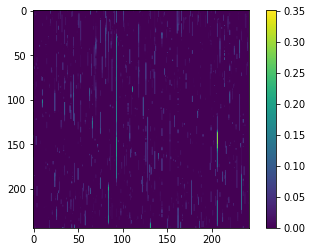

In [254]:
plt.imshow(weights_svm[weights_svm.columns[(weights_svm > 0.001).any(axis = 0)]])
plt.colorbar()

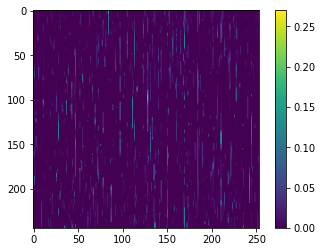

In [255]:
plt.imshow(weights_mvo[weights_mvo.columns[(weights_mvo > 0.001).any(axis = 0)]])
plt.colorbar();

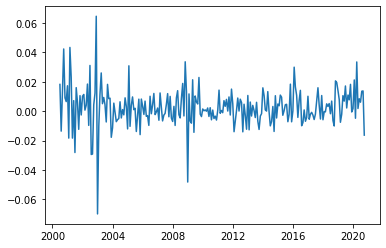

In [256]:
excess = oot_returns_svm - oot_returns_mvo
plt.plot(oot_returns_svm - oot_returns_mvo)

In [257]:
print('mvo turnover proxy', weights_mvo.diff().abs().sum(axis = 1).sum())
print('svm turnover proxy', weights_svm.diff().abs().sum(axis = 1).sum())

mvo turnover proxy 50.62392085064789
svm turnover proxy 50.62500590599567


In [258]:
np.abs(SVM_MVO_Slck.w.x).mean()

0.09899402414191628

In [259]:
1/np.maximum(1, prices.iloc[0])

AAPL    1.000000
ABC     0.373163
ABMD    0.097561
ABT     0.091830
ADBE    0.058779
          ...   
XOM     0.052285
XRAY    0.150013
XRX     0.021264
YUM     0.187588
ZBRA    0.038136
Name: 1999-11-01 00:00:00, Length: 286, dtype: float64

In [260]:
oot_returns_mvo.std()

0.03443205608168673

In [261]:
oot_returns_svm.std()

0.03525537056152896

In [262]:
oot_returns_mvo.mean()/oot_returns_mvo.std()

0.5208296787040139

In [263]:
oot_returns_svm.mean()/oot_returns_svm.std()

0.58124563465946

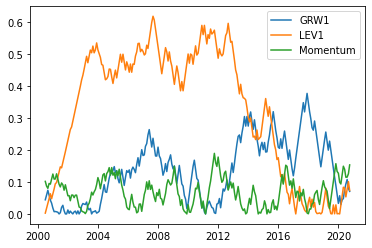

In [265]:
plt.plot(rets.index[:T], wis_svm);
plt.legend(cols);

In [266]:
(1 +rets).cumprod().iloc[-1].sort_values()

JNPR      0.258314
XRX       0.370939
DVN       0.385910
APA       0.453264
F         0.462877
           ...    
KMX      69.573952
HUM      76.032476
ANSS    120.377524
TSCO    169.500361
AAPL    169.840234
Name: 2020-10-01 00:00:00, Length: 286, dtype: float64

In [267]:
RetStats(oot_returns_svm)

(0.24590436284628414, 0.12212818610447253, 2.0134939418156046)

In [268]:
RetStats(oot_returns_mvo)

(0.21519884047372184, 0.11927614108508473, 1.8042069312102524)

In [269]:
mth

Timestamp('2000-07-01 00:00:00')

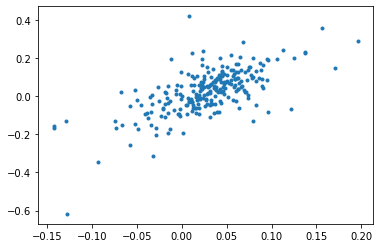

In [270]:
plt.plot(pd.Series([forecasts[mth][1][0][0] for mth in rets.index.to_list()]), rets.iloc[:,0], '.')